# HuggingTweets - Tweet Generation with Huggingface

*Disclaimer: this project is not to be used to publish any false generated information but to perform research on Natural Language Generation (NLG).*

## Install dependencies

In [101]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [102]:
import json
with open('credentials.json','r') as f:
    credentials = json.load(f)

## Download tweets from a user

We download latest tweets associated to a user account through [Tweepy](http://docs.tweepy.org/).

In [103]:
import tweepy

In [104]:
# authenticate
auth = tweepy.AppAuthHandler(credentials.get('api_key'), credentials.get('api_secret'))
api = tweepy.API(auth)

We grab all available tweets (limited to 3200 per API limitations) based on Twitter handle.

**Note**: Protected users may only be requested when the authenticated user either "owns" the timeline or is an approved follower of the owner.

In [105]:
# <--- Enter the screen name of the user you will download your dataset from --->
handle = 'elonMusk'

In [106]:
new_tweets = api.user_timeline(
        screen_name=handle, tweet_mode='extended', count=200)

In [107]:
# Adapted from https://gist.github.com/onmyeoin/62c72a7d61fc840b2689b2cf106f583c

# initialize a list to hold all the tweepy Tweets & list with no retweets
alltweets = []

# make initial request for most recent tweets with extended mode enabled to get full tweets
new_tweets = api.user_timeline(
    screen_name=handle, tweet_mode='extended', count=200)

# save most recent tweets
alltweets.extend(new_tweets)

# save the id of the oldest tweet less one
oldest = alltweets[-1].id - 1

# check we cannot get more tweets
no_tweet_count = 0

# keep grabbing tweets until the api limit is reached
while True:
    print(f'getting tweets before id {oldest}')

    # all subsequent requests use the max_id param to prevent duplicates
    new_tweets = api.user_timeline(
        screen_name=handle, tweet_mode='extended', count=200, max_id=oldest)
    
    # stop if no more tweets (try a few times as they sometimes eventually come)
    if not new_tweets:
        no_tweet_count +=1
    else:
        no_tweet_count = 0
    if no_tweet_count > 5: break

    # save most recent tweets
    alltweets.extend(new_tweets)

    # update the id of the oldest tweet less one
    oldest = alltweets[-1].id - 1

    print(f'...{len(alltweets)} tweets downloaded so far')

getting tweets before id 1264278385200517119
...400 tweets downloaded so far
getting tweets before id 1258644775852322815
...600 tweets downloaded so far
getting tweets before id 1254632509863866367
...800 tweets downloaded so far
getting tweets before id 1250614618805821439
...1000 tweets downloaded so far
getting tweets before id 1243274074832371712
...1200 tweets downloaded so far
getting tweets before id 1235671666572668928
...1400 tweets downloaded so far
getting tweets before id 1225352310051758080
...1600 tweets downloaded so far
getting tweets before id 1217742268393607167
...1800 tweets downloaded so far
getting tweets before id 1209217693108318207
...2000 tweets downloaded so far
getting tweets before id 1197987290317914111
...2200 tweets downloaded so far
getting tweets before id 1186369486800113663
...2400 tweets downloaded so far
getting tweets before id 1177662806117584895
...2600 tweets downloaded so far
getting tweets before id 1171802135383564288
...2799 tweets downloa

Text(0.5, 0, 'Month')

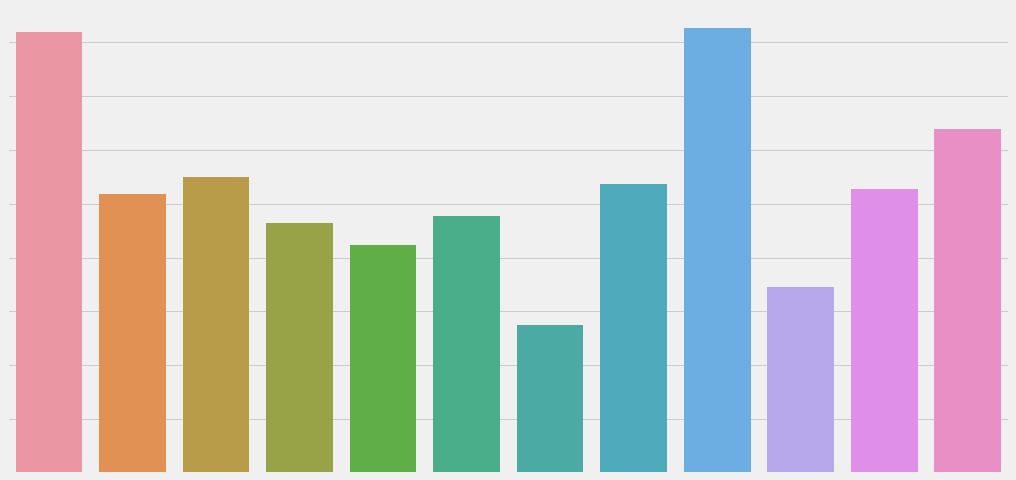

In [132]:
all_months = pd.DataFrame({'tweet_month':[vars(status)['created_at'].strftime('%b-%Y') for status in alltweets]})
monthly = all_months.groupby('tweet_month').size().reset_index(name='counts')
fig, ax = plt.subplots(figsize=(16,8))
sns.barplot(x=monthly['tweet_month'],y=monthly['counts'],ax=ax)
ax.set_ylabel('Num Tweets')
ax.set_xlabel('Month')

## Create a dataset from downloaded tweets

We remove:
* retweets (since it's not in the wording style of target author)
* tweets with no interesting content (limited to url's, user mentionss, "thank you"…)

We clean up remaining tweets:
* we remove url's
* we replace "@" mentions with user names

In [109]:
import random
import re
import torch

In [110]:
class user_handle:
    'Get a user handle and cache it to avoid calling too much twitter api.'
    handles = {}
    def get(handle):
        if handle not in user_handle.handles.keys():            
            try:
                user_handle.handles[handle] = api.get_user(handle).name
            except:
                user_handle.handles[handle] = None
        return user_handle.handles[handle]

In [111]:
def replace_handle(word):
    'Replace user handles, remove "@" and "#"'
    if word[0] == '@':
        handle = re.search('^@(\w)+', word)
        if handle:
            user = user_handle.get(handle.group())
            if user is not None: return user + word[handle.endpos:]
    return word

In [112]:
def keep_tweet(tweet):
    'Return true if not a retweet'
    if hasattr(tweet, 'retweeted_status'):
        return False
    return True

In [113]:
def curate_tweets(tweets):
    'Decide which tweets we keep and replace handles'
    curated_tweets = []
    for tweet in tweets:
        if keep_tweet(tweet):
            curated_tweets.append(' '.join(replace_handle(w) for w in tweet.full_text.split()))
    return curated_tweets

In [114]:
curated_tweets = curate_tweets(alltweets)

We verify our list of tweets is well curated.

In [115]:
print(f'Total number of tweets: {len(alltweets)}\nCurated tweets: {len(curated_tweets)}')

Total number of tweets: 3202
Curated tweets: 2940


In [116]:
print('Original tweets\n')
for t in alltweets[:5]:
    print(f'{t.full_text}\n')

Original tweets

RT @SpaceX: More than 100 spacecraft have been signed up to fly on Falcon 9 since we launched the rideshare program. Small satellite operat…

RT @tegmark: Help us find an unsung hero! If they win, they get $50k &amp; you get up to $3k for nominating/spreading the word. Our first 3 awa…

@NYYScoreKeep Not sure. They’re pretty close together.

@westcoastbill It will be real

@cisoml @Erdayastronaut @russ_parrish Maybe Incat https://t.co/qHbJcMocFg



In [117]:
print('Curated tweets\n')
for t in curated_tweets[:5]:
    print(f'{t}\n')

Curated tweets

NYYaker Not sure. They’re pretty close together.

bill lee 🚀🇺🇸 It will be real

Ciso M Lins Everyday Astronaut Russ Parrish Maybe Incat https://t.co/qHbJcMocFg

Viv 🐉 There will be many test flights before commercial passengers are carried. First Earth to Earth test flights might be in 2 or 3 years.

Everyday Astronaut Russ Parrish We need to be far enough away so as not to bother heavily populated areas. The launch &amp; landing are not subtle. But you could get within a few miles of the spaceport in a boat.



We remove boring tweets (tweets with only urls or too short) and cleanup texts.

In [118]:
def cleanup_tweet(tweet):
    "Clean tweet text"
    text = ' '.join(t for t in tweet.split() if 'http' not in t)
    text = text.replace('&amp;', '&')
    text = text.replace('&lt;', '<')
    text = text.replace('&gt;', '>')
    if text.split() and text.split()[0] == '.':
         text = ' '.join(text.split()[1:])
    return text

In [119]:
def boring_tweet(tweet):
    "Check if this is a boring tweet"
    boring_stuff = ['http', '@', '#', 'thank', 'thanks', 'I', 'you']
    if len(tweet.split()) < 3:
        return True
    if all(any(bs in t.lower() for bs in boring_stuff) for t in tweet):
        return True
    return False

In [120]:
clean_tweets = [cleanup_tweet(t) for t in curated_tweets]
cool_tweets = [tweet for tweet in clean_tweets if not boring_tweet(tweet)]
print(f'Curated tweets: {len(curated_tweets)}\nCool tweets: {len(cool_tweets)}')

Curated tweets: 2940
Cool tweets: 2753


We split data into training and validation sets (90/10).

In [121]:
# shuffle data
random.shuffle(cool_tweets)

# fraction of training data
split_train_valid = 0.9

# split dataset
train_size = int(split_train_valid * len(cool_tweets))
valid_size = len(cool_tweets) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(cool_tweets, [train_size, valid_size])

In [122]:
with open(f"./tweets_cache/{handle}_train.txt", 'w') as f:
    f.write('\n'.join(train_dataset))

with open(f"./tweets_cache/{handle}_valid.txt", 'w') as f:
    f.write('\n'.join(valid_dataset))

In [124]:
from simpletransformers.language_modeling import LanguageModelingModel

In [125]:
import logging
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

train_args = {
    "output_dir": "gpt2_outputs/",
    "reprocess_input_data": True,
    "overwrite_output_dir": True,
    "fp16": False,
    "train_batch_size": 32,
    "eval_batch_size":32,
    "num_train_epochs": 8,
    "tensorboard_dir": 'gpt2_tweet_runs/',
    'mlm':False
}

model = LanguageModelingModel('gpt2', 'gpt2', args=train_args,use_cuda=False)

model.train_model(f"./tweets_cache/{handle}_train.txt", eval_file=f"./tweets_cache/{handle}_valid.txt")

INFO:simpletransformers.language_modeling.language_modeling_utils: Creating features from dataset file at cache_dir/
 Creating features from dataset file at cache_dir/


INFO:simpletransformers.language_modeling.language_modeling_utils: Saving features into cached file cache_dir/gpt2_cached_lm_126_elonMusk_train.txt
 Saving features into cached file cache_dir/gpt2_cached_lm_126_elonMusk_train.txt
INFO:simpletransformers.language_modeling.language_modeling_model: Training started
 Training started


Running loss: 5.139063


Running loss: 4.793602


Running loss: 4.469554


Running loss: 4.455385

/nfs/orto/home/pradhyum/.conda/envs/my_root/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 4.519169


Running loss: 4.079566


Running loss: 3.948889


Running loss: 4.120066


Running loss: 4.224104



INFO:simpletransformers.language_modeling.language_modeling_model: Training of gpt2 model complete. Saved to gpt2_outputs/.
 Training of gpt2 model complete. Saved to gpt2_outputs/.


## Let's test our trained model!

In [127]:
from simpletransformers.language_generation import LanguageGenerationModel
gen_args={'length':200,
         'k':10}
model = LanguageGenerationModel("gpt2", "gpt2_outputs/",use_cuda=False, args=gen_args)
model.generate("There is no",verbose=False)

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


['There is no question that there will be some improvements coming out of the factory in a few months.Tesla Owners Silicon Valley 🇵🇷🛩🔋🔧 @matthewlindy We can’t be done with just the right tools, but there’s a way to get there, and we’re doing our best to solve that problem.John K. Brown🚀 @matthewlindy Tesla is a great place to start a new career. The team is amazing!🤣🤣🤣Tesla Owners Silicon Valley 🐉 Tesla Podcast Everyday Astronaut Astronaut YesJohn Kraus 🚀 Tesla Podcast Yeah! We’re going to use the same technology as our competitors! It’s a great opportunity to test out new concepts, improve our design, & improve our customer experience. That is what we’re working towards.Tesla Owners Silicon Valley 🐉 Tesla Podcast']

In [42]:
'''profile = api.get_user(id=handle)
    image_url = profile.profile_image_url[:63]+profile.profile_image_url[70:]
    urllib.request.urlretrieve(image_url,f'{handle}.jpg')
    image = Image.open('sunrise.jpg')
    st.image(image)'''

"profile = api.get_user(id=handle)\n    image_url = profile.profile_image_url[:63]+profile.profile_image_url[70:]\n    urllib.request.urlretrieve(image_url,f'{handle}.jpg')\n    image = Image.open('sunrise.jpg')\n    st.image(image)"

Credit to Boris Dayma for the original repo that this is forked from.